In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout,Input

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras


# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
import tempfile
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Using TensorFlow backend.


In [2]:
'''
1. Data Augmentation method   
'''
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

'''
2. Extracting the MFCC feature as an image (Matrix format).  
'''
def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 3))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X


'''
3. Confusion matrix plot 
'''        
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
'''
# 4. Create the 2D CNN model 
'''
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass=14
    model_d=MobileNetV2(weights="imagenet" ,include_top=False, input_shape=(n, 216, 3)) 
    
    x=model_d.output

    x= GlobalAveragePooling2D()(x)
    x= BatchNormalization()(x)
    x= Dropout(0.5)(x)
    x= Dense(1024,activation='relu')(x) 
    x= Dense(512,activation='relu')(x) 
    x= Dense(256,activation='relu')(x)
    x= BatchNormalization()(x)
    x= Dropout(0.3)(x)

    out=Dense(nclass,activation='softmax')(x) #FC-layer
    model = Model(inputs=model_d.input , outputs=out)
    
    opt = Adam(0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
    return model
    
'''
# 5. Other functions 
'''
class get_results:
    '''
    We're going to create a class (blueprint template) for generating the results based on the various model approaches. 
    So instead of repeating the functions each time, we assign the results into on object with its associated variables 
    depending on each combination:
        1) MFCC with no augmentation  
        2) MFCC with augmentation 
        3) Logmelspec with no augmentation 
        4) Logmelspec with augmentation
    '''
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)
    
    def accuracy_results_gender(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''
    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
        
        actual = pd.DataFrame(actual).replace({'female_angry':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happy':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'male_angry':'male'
                   , 'male_fear':'male'
                   , 'male_happy':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                  })
        preds = pd.DataFrame(preds).replace({'female_angry':'female'
               , 'female_disgust':'female'
               , 'female_fear':'female'
               , 'female_happy':'female'
               , 'female_sad':'female'
               , 'female_surprise':'female'
               , 'female_neutral':'female'
               , 'male_angry':'male'
               , 'male_fear':'male'
               , 'male_happy':'male'
               , 'male_sad':'male'
               , 'male_surprise':'male'
               , 'male_neutral':'male'
               , 'male_disgust':'male'
              })

        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)

In [3]:
ref = pd.read_csv("./kaggle/input/data-path/dp.csv")
ref.head()

,labels,source,path
0,male_angry,SAVEE,./kaggle/input/surrey-audiovisual-expressed-em...
1,male_angry,SAVEE,./kaggle/input/surrey-audiovisual-expressed-em...
2,male_angry,SAVEE,./kaggle/input/surrey-audiovisual-expressed-em...
3,male_angry,SAVEE,./kaggle/input/surrey-audiovisual-expressed-em...
4,male_angry,SAVEE,./kaggle/input/surrey-audiovisual-expressed-em...


In [4]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 128
mfcc = prepare_data(ref, n = n_mfcc, aug = 0, mfcc = 1)

100%|██████████████████████████████████████████████████████████████████████████████| 5732/5732 [03:20<00:00, 28.63it/s]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


# one hot encode the target 
lb = LabelEncoder()
y_train = tf.keras.utils.to_categorical(lb.fit_transform(y_train))
y_test = tf.keras.utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=32, verbose = 2, epochs=20)

9412608/9406464 [==============================] - 5s 0us/step
Train on 4299 samples, validate on 1433 samples
Epoch 1/20
4299/4299 - 31s - loss: 1.4262 - acc: 0.5387 - val_loss: 9.2298 - val_acc: 0.1996
Epoch 2/20
4299/4299 - 21s - loss: 0.8144 - acc: 0.7118 - val_loss: 7.2079 - val_acc: 0.2177
Epoch 3/20
4299/4299 - 21s - loss: 0.6869 - acc: 0.7569 - val_loss: 3.4558 - val_acc: 0.4613
Epoch 4/20
4299/4299 - 21s - loss: 0.5761 - acc: 0.7976 - val_loss: 2.2911 - val_acc: 0.5792
Epoch 5/20
4299/4299 - 21s - loss: 0.4799 - acc: 0.8381 - val_loss: 4.7689 - val_acc: 0.3447
Epoch 6/20
4299/4299 - 21s - loss: 0.4565 - acc: 0.8458 - val_loss: 2.5456 - val_acc: 0.4794
Epoch 7/20
4299/4299 - 21s - loss: 0.3428 - acc: 0.8765 - val_loss: 2.4539 - val_acc: 0.4969
Epoch 8/20
4299/4299 - 21s - loss: 0.3415 - acc: 0.8832 - val_loss: 1.6668 - val_acc: 0.6281
Epoch 9/20
4299/4299 - 21s - loss: 0.2995 - acc: 0.8979 - val_loss: 1.6669 - val_acc: 0.5715
Epoch 10/20
4299/4299 - 21s - loss: 0.2821 - acc: 0.

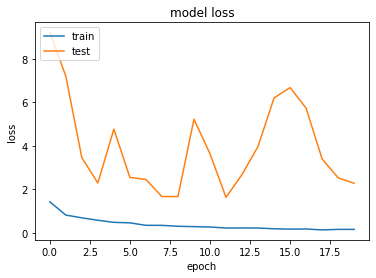

accuracy: 62.39%
1433/1433 - 3s


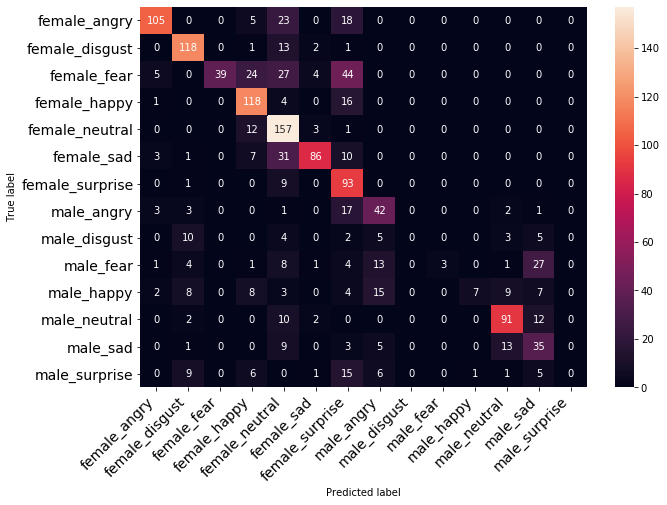

In [6]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

In [7]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 128
mfcc_aug = prepare_data(ref, n = n_mfcc, aug = 1, mfcc = 1)

100%|██████████████████████████████████████████████████████████████████████████████| 5732/5732 [03:03<00:00, 31.23it/s]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_aug
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# one hot encode the target 
lb = LabelEncoder()
y_train = tf.keras.utils.to_categorical(lb.fit_transform(y_train))
y_test = tf.keras.utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
# mean = np.mean(X_train, axis=0)
# std = np.std(X_train, axis=0)

# X_train = (X_train - mean)/std
# X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=32, verbose = 2, epochs=20)

Train on 4299 samples, validate on 1433 samples
Epoch 1/20
4299/4299 - 30s - loss: 1.4508 - acc: 0.5338 - val_loss: 4.7517 - val_acc: 0.2135
Epoch 2/20
4299/4299 - 21s - loss: 0.9088 - acc: 0.6785 - val_loss: 3.6908 - val_acc: 0.2631
Epoch 3/20
4299/4299 - 21s - loss: 0.7343 - acc: 0.7365 - val_loss: 3.2670 - val_acc: 0.3573
Epoch 4/20
4299/4299 - 21s - loss: 0.6247 - acc: 0.7772 - val_loss: 1.8808 - val_acc: 0.4864
Epoch 5/20
4299/4299 - 21s - loss: 0.5456 - acc: 0.8030 - val_loss: 1.7506 - val_acc: 0.5645
Epoch 6/20
4299/4299 - 21s - loss: 0.4955 - acc: 0.8265 - val_loss: 2.2817 - val_acc: 0.5464
Epoch 7/20
4299/4299 - 22s - loss: 0.4630 - acc: 0.8369 - val_loss: 4.6075 - val_acc: 0.2791
Epoch 8/20
4299/4299 - 21s - loss: 0.5624 - acc: 0.8114 - val_loss: 3.7733 - val_acc: 0.3385
Epoch 9/20
4299/4299 - 21s - loss: 0.5765 - acc: 0.7986 - val_loss: 3.8826 - val_acc: 0.3971
Epoch 10/20
4299/4299 - 21s - loss: 0.4268 - acc: 0.8530 - val_loss: 1.7164 - val_acc: 0.5736
Epoch 11/20
4299/4299

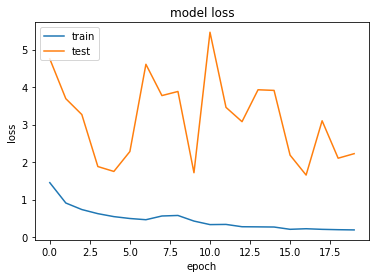

accuracy: 56.73%
1433/1433 - 2s


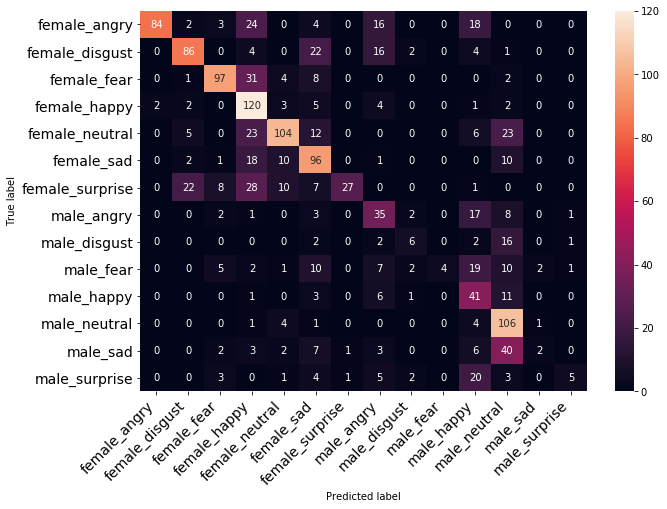

In [9]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

In [10]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 128
specgram = prepare_data(ref, n = n_melspec, aug = 0, mfcc = 0)

100%|██████████████████████████████████████████████████████████████████████████████| 5732/5732 [02:47<00:00, 34.17it/s]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = tf.keras.utils.to_categorical(lb.fit_transform(y_train))
y_test = tf.keras.utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=32, verbose = 2, epochs=20)

Train on 4299 samples, validate on 1433 samples
Epoch 1/20
4299/4299 - 28s - loss: 1.4356 - acc: 0.5376 - val_loss: 4.3184 - val_acc: 0.2722
Epoch 2/20
4299/4299 - 21s - loss: 0.8463 - acc: 0.7027 - val_loss: 6.3683 - val_acc: 0.2819
Epoch 3/20
4299/4299 - 21s - loss: 0.7027 - acc: 0.7590 - val_loss: 6.8542 - val_acc: 0.2840
Epoch 4/20
4299/4299 - 21s - loss: 0.6268 - acc: 0.7904 - val_loss: 5.7917 - val_acc: 0.3196
Epoch 5/20
4299/4299 - 21s - loss: 0.5455 - acc: 0.8155 - val_loss: 2.7928 - val_acc: 0.4843
Epoch 6/20
4299/4299 - 21s - loss: 0.4524 - acc: 0.8479 - val_loss: 3.4611 - val_acc: 0.4682
Epoch 7/20
4299/4299 - 21s - loss: 0.4135 - acc: 0.8572 - val_loss: 6.6250 - val_acc: 0.2415
Epoch 8/20
4299/4299 - 21s - loss: 0.3841 - acc: 0.8681 - val_loss: 6.2472 - val_acc: 0.2701
Epoch 9/20
4299/4299 - 21s - loss: 0.3152 - acc: 0.8949 - val_loss: 5.6560 - val_acc: 0.3203
Epoch 10/20
4299/4299 - 21s - loss: 0.3296 - acc: 0.8881 - val_loss: 3.2579 - val_acc: 0.4689
Epoch 11/20
4299/4299

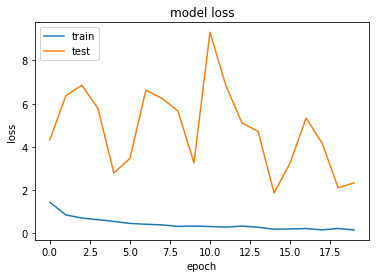

accuracy: 58.20%
1433/1433 - 2s


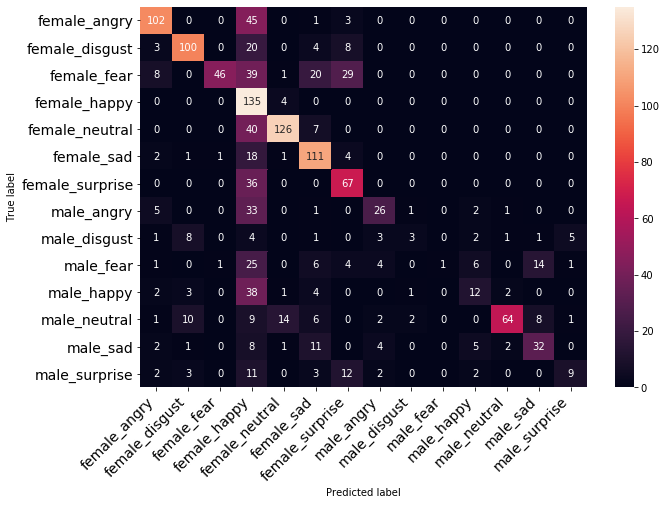

In [12]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

In [13]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 128
aug_specgram = prepare_data(ref,  n = n_melspec, aug = 1, mfcc = 0)

100%|██████████████████████████████████████████████████████████████████████████████| 5732/5732 [02:58<00:00, 32.10it/s]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(aug_specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = tf.keras.utils.to_categorical(lb.fit_transform(y_train))
y_test = tf.keras.utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=32, verbose = 2, epochs=20)

Train on 4299 samples, validate on 1433 samples
Epoch 1/20
4299/4299 - 30s - loss: 1.3928 - acc: 0.5508 - val_loss: 4.3139 - val_acc: 0.2261
Epoch 2/20
4299/4299 - 22s - loss: 0.8677 - acc: 0.6978 - val_loss: 4.3104 - val_acc: 0.3008
Epoch 3/20
4299/4299 - 22s - loss: 0.7318 - acc: 0.7427 - val_loss: 4.1929 - val_acc: 0.3964
Epoch 4/20
4299/4299 - 22s - loss: 0.6536 - acc: 0.7669 - val_loss: 4.3333 - val_acc: 0.3922
Epoch 5/20
4299/4299 - 22s - loss: 0.5748 - acc: 0.7948 - val_loss: 1.6310 - val_acc: 0.6190
Epoch 6/20
4299/4299 - 22s - loss: 0.5591 - acc: 0.8072 - val_loss: 4.8227 - val_acc: 0.3475
Epoch 7/20
4299/4299 - 22s - loss: 0.4853 - acc: 0.8251 - val_loss: 6.1746 - val_acc: 0.3566
Epoch 8/20
4299/4299 - 22s - loss: 0.4528 - acc: 0.8388 - val_loss: 6.0966 - val_acc: 0.3650
Epoch 9/20
4299/4299 - 22s - loss: 0.4247 - acc: 0.8528 - val_loss: 3.6690 - val_acc: 0.4941
Epoch 10/20
4299/4299 - 22s - loss: 0.3362 - acc: 0.8828 - val_loss: 5.2943 - val_acc: 0.3252
Epoch 11/20
4299/4299

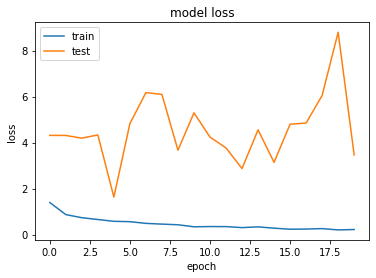

accuracy: 47.10%
1433/1433 - 3s


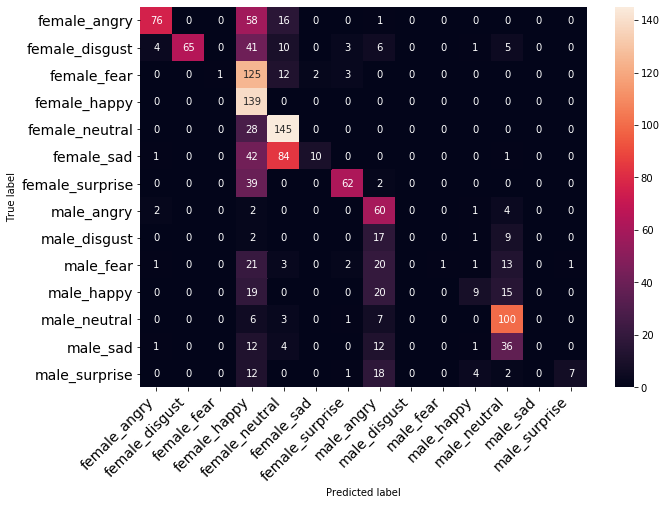

In [15]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

1433/1433 - 2s
0.9246336357292394


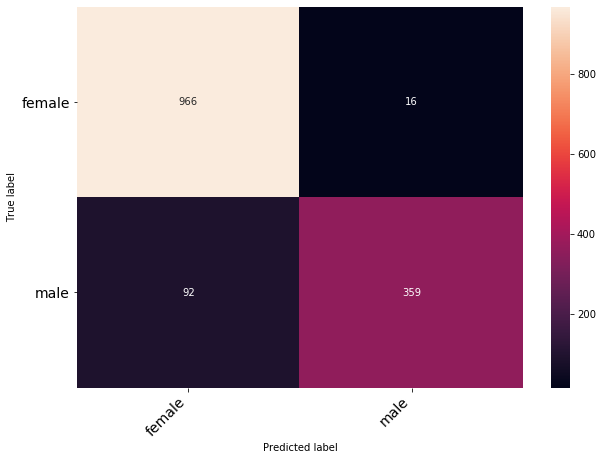

In [16]:
results.accuracy_results_gender(X_test, y_test, ref.labels.unique(), model)